# 3D plot of a detector from a '.poni' file
This is a quick and easy sanity check for after converting a file from heXRD coordinates.

In [58]:
import pyFAI
import numpy as np
import matplotlib.pyplot as plt

In [59]:
def pyfai_rotation_matrix():
    """ The rotation order is 1 -> 2 -> 3.
    Rotation 3 is right-handed, Rotations 1 and 2 are left-handed.
    The heXRD lab coordinates map to the pyFAI coordinates as follows:
    Z = -X_3
    Y = X_1
    X = X_2
    """
    cosrot1 = np.cos(theta1)
    sinrot1 = np.sin(theta1)
    cosrot2 = np.cos(theta2)
    sinrot2 = np.sin(theta2)
    cosrot3 = np.cos(theta3)
    sinrot3 = np.sin(theta3)

    rot3_mat = np.array([[cosrot3, -sinrot3, 0],
                         [sinrot3, cosrot3, 0],
                         [0, 0, 1]])

    rot2_mat = np.array([[cosrot2, 0, -sinrot2],
                         [0, 1, 0],
                         [sinrot2, 0, cosrot2]])

    rot1_mat = np.array([[1, 0, 0],
                         [0, cosrot1, sinrot1],
                         [0, -sinrot1, cosrot1]])

    rotation_matrix = np.dot(np.dot(rot3_mat, rot2_mat), rot1_mat)
    # order is 3, 2, 1 because matrices
    return rotation_matrix

In [68]:
poni_name = 'V1_test'
path = '../'

In [69]:
poni = pyFAI.load(path+poni_name+'.poni')

distance = poni.get_dist()
poni1, poni2 = poni.get_poni1(), poni.get_poni2()
theta1, theta2, theta3 = poni.get_rot1(), poni.get_rot2(), poni.get_rot3()
pixel1, pixel2 = poni.get_pixel1(), poni.get_pixel2()
wavelength = poni.get_wavelength()
shape = poni.get_shape()
rotation_matrix_pyfai = pyfai_rotation_matrix()

In [70]:
id1, id2 = np.arange(0, shape[0], 1)*pixel1, np.arange(0, shape[1], 1)*pixel2
p1_pixel, p2_pixel = np.meshgrid(id2, id1)
p3_pixel = None

size = p1_pixel.size

p2 = (p2_pixel - poni2).ravel() ## axis 2: horizontal and perpendicular to beam
p1 = (p1_pixel - poni1).ravel() ## axis 1: vertical and perpendicular to beam
p3 = np.zeros(size) + distance

## Pixel position in the detector frame centered at the sample position
## To get the same orientation as pyFAI for the rotation (axis1, axis2, axis3) triad (vertical axis, horizontal axis, along X-ray beam)
coord_det = np.vstack((p1, p2, p3))

## Pixel position in the sample frame
COORD_SAMPLE = np.dot(rotation_matrix_pyfai, coord_det)

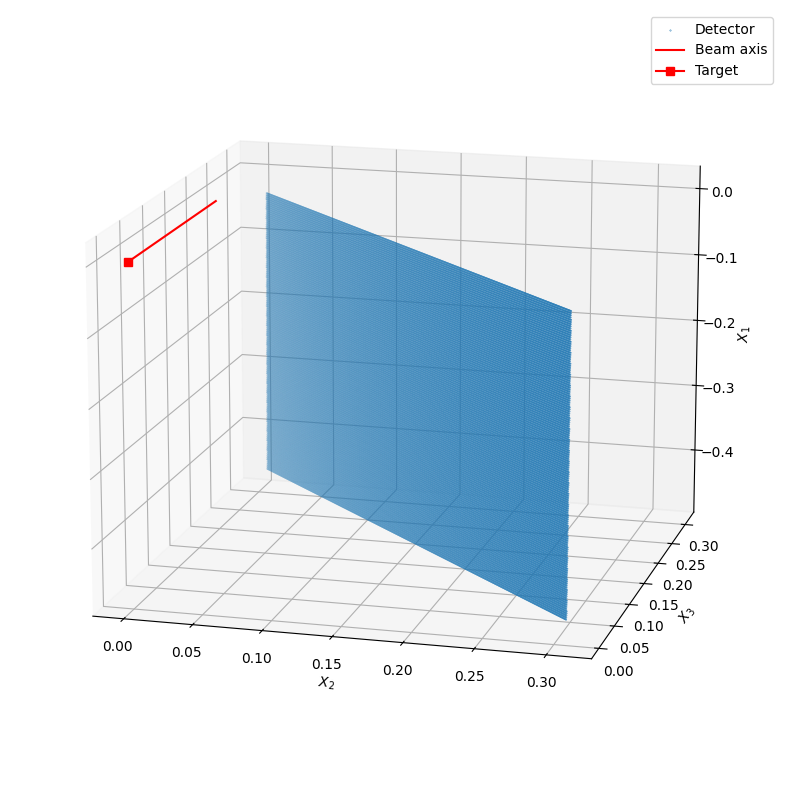

In [74]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(COORD_SAMPLE[1, ::100], COORD_SAMPLE[2, ::100], COORD_SAMPLE[0, ::100], s=0.1, label='Detector')
ax.plot3D([0, 0], [0, 0.2], [0, 0], 'red', label='Beam axis')
ax.plot(0, 0, 0, marker='s', c='red', label='Target')
ax.view_init(elev=15, azim=-75)
ax.set_xlabel('$X_2$')
ax.set_ylabel('$X_3$')
ax.set_zlabel('$X_1$')
plt.legend()
plt.show()